# Import Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout
import matplotlib.pyplot as plt


# Data Preprocessing

In [2]:
# Load the data
data = pd.read_csv('../datasets/nflx.csv')
data.head()

# Reset index
data.reset_index(drop=True, inplace=True)

# Select numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Fill NaN values in numeric columns with the mean of those columns
data[numeric_data.columns] = data[numeric_data.columns].fillna(numeric_data.mean())

# Display the first few rows of the DataFrame
print(data.head())

# Calculate moving average
ma_day = [5, 10, 20, 50]  # Common short-term and long-term windows
for ma in ma_day:
    column_name = f"MA for {ma} days"
    data[column_name] = data['Close'].rolling(window=ma).mean()

# Calculate Exponential moving average
for ma in ma_day:
    column_name = f"EMA for {ma} days"
    data[column_name] = data['Close'].ewm(span=ma, adjust=False).mean()

# Calculate RSI
def compute_RSI(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

data['RSI_14'] = compute_RSI(data)

# Remove any rows with NaN values
data.dropna(inplace=True)
data.head(500)

         Date   Open   High    Low  Close   Volume
0  2005-01-03  12.48  12.60  11.52  11.92  1619200
1  2005-01-04  11.92  11.95  11.25  11.66  2478900
2  2005-01-05  11.74  11.74  11.09  11.20  1818900
3  2005-01-06  11.20  11.37  11.01  11.05  1181900
4  2005-01-07  11.11  11.55  11.00  11.12  1070100


,Date,Open,High,Low,Close,Volume,MA for 5 days,MA for 10 days,MA for 20 days,MA for 50 days,EMA for 5 days,EMA for 10 days,EMA for 20 days,EMA for 50 days,RSI_14
49,2005-03-15,9.47,9.62,9.12,9.20,1505100,9.606,10.068,10.3665,10.9282,9.589113,9.913983,10.289715,10.825425,34.482759
50,2005-03-16,9.11,9.32,9.10,9.17,1037200,9.438,9.917,10.2625,10.8732,9.449408,9.778714,10.183075,10.760506,29.568106
51,2005-03-17,9.22,9.24,9.15,9.20,650700,9.300,9.781,10.1750,10.8240,9.366272,9.673493,10.089449,10.699310,13.469388
52,2005-03-18,9.25,9.25,9.15,9.20,997600,9.254,9.631,10.1100,10.7840,9.310848,9.587403,10.004740,10.640513,15.277778
53,2005-03-21,9.25,9.50,9.16,9.31,884900,9.216,9.503,10.0420,10.7492,9.310565,9.536966,9.938574,10.588336,16.055046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,2007-03-05,22.01,22.16,21.05,21.06,2443000,22.162,22.812,22.8400,23.6432,22.106463,22.480152,22.780457,23.662933,33.492823
545,2007-03-06,21.25,21.91,20.91,21.44,2019000,22.030,22.605,22.7820,23.5308,21.884308,22.291033,22.652794,23.575759,38.629283
546,2007-03-07,21.50,21.60,21.07,21.18,1228500,21.760,22.384,22.7250,23.4072,21.649539,22.089027,22.512528,23.481808,38.871473
547,2007-03-08,21.21,21.63,21.21,21.24,902900,21.442,22.133,22.6420,23.2962,21.513026,21.934659,22.391335,23.393894,40.063091


# Feature Engineering 

In [3]:
feature_columns = [
    'Close',          
    'Low',            
    'High',          
    'Open',           
    'EMA for 5 days', 
    'MA for 5 days',  
    'RSI_14'   
]    

features = data[feature_columns].values

# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 15  # 15-day window
X, y = create_sequences(scaled_data, seq_length)

# Split 80/20 chronologically
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Check for NaN and Inf values
print(np.isnan(X_train).any(), np.isnan(y_train).any())
print(np.isinf(X_train).any(), np.isinf(y_train).any())

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

False False
False False
Training samples: 1962, Testing samples: 491
X_train shape: (1962, 15, 7), y_train shape: (1962,)


# Load the saved model

In [4]:
# Load the saved model
model = tf.keras.models.load_model('gru_lstm_model.keras')

c:\Users\timoz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Predictions

In [5]:
# Prediction
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values

# Need to create dummy array for inverse scaling as y is only 'Close'
y_pred_scaled = np.zeros((len(y_pred), len(feature_columns)))
y_pred_scaled[:, 0] = y_pred[:, 0]  
y_pred = scaler.inverse_transform(y_pred_scaled)[:, 0]  
y_test_scaled = np.zeros((len(y_test), len(feature_columns)))
y_test_scaled[:, 0] = y_test 
y_test = scaler.inverse_transform(y_test_scaled)[:, 0]  

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


# Evaluation Metrics

Performance Metrics
MAE: 13.06
RMSE: 17.40
R^2: 0.97
MAPE: 4.06%


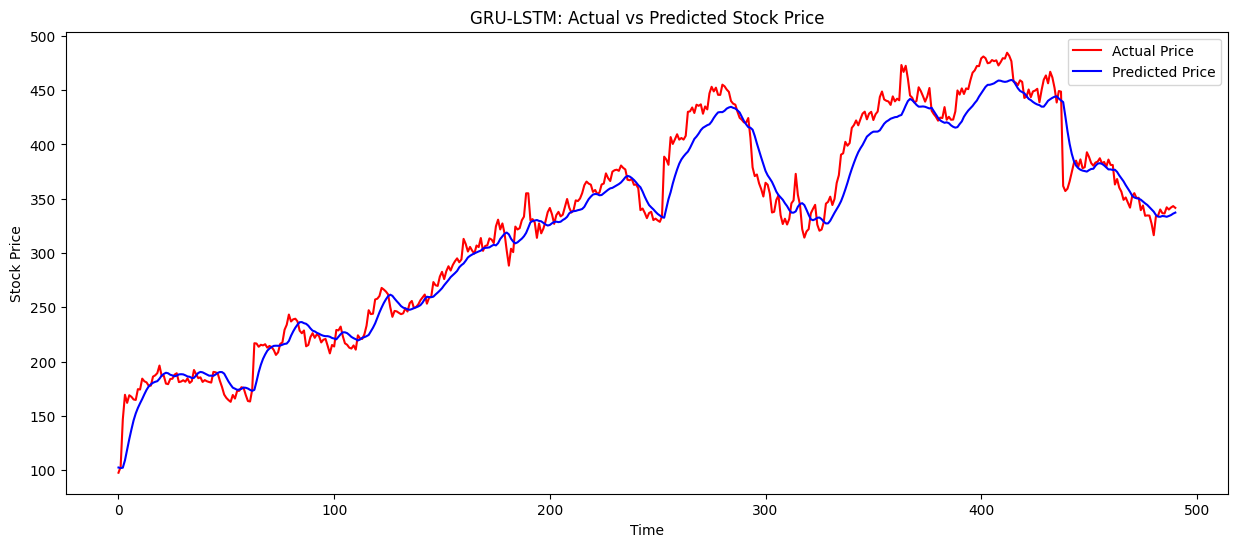

In [6]:
# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("Performance Metrics")
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R^2: {r2:.2f}')
print(f'MAPE: {mape:.2f}%')

# Plot 
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='Actual Price', color='red')
plt.plot(y_pred, label='Predicted Price', color='blue')
plt.title('GRU-LSTM: Actual vs Predicted Stock Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()



# Save Metrics

In [8]:
def save_metrics(test_label, predicted, model_name, stock_name):
    """
    Calculate metrics and save to CSV.
    
    Parameters:
    - test_label: Actual values (y_test)
    - predicted: Predicted values (y_pred)
    - model_name: Name of the model (e.g., 'GRU-LSTM')
    - stock_name: Name of the stock (e.g., 'MSFT')
    """
    # Calculate metrics
    mse = mean_squared_error(test_label, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_label, predicted)
    mape = np.mean(np.abs((test_label - predicted) / test_label)) * 100
    r2 = r2_score(test_label, predicted)
    
    # Round to 4 decimal places
    mse = round(mse, 4)
    rmse = round(rmse, 4)
    mae = round(mae, 4)
    mape = round(mape, 4)
    r2 = round(r2, 4)
    
    # Create metrics dictionary
    metrics = {
        'Model': [model_name],
        'Stock': [stock_name],
        'RMSE': [rmse],
        'MAE': [mae],
        'MAPE': [mape],
        'R2': [r2]
    }
    
    # Convert to DataFrame
    df_metrics = pd.DataFrame(metrics)
    
    # Save to CSV
    filename = f'metrics_{model_name}_{stock_name}.csv'
    df_metrics.to_csv(filename, index=False)
    
    # Print metrics
    print(f"\nMetrics for {model_name} on {stock_name}:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
    print(f"R² Score: {r2:.4f}")

save_metrics(y_test, y_pred, model_name="GRU-LSTM", stock_name="NFLX")


Metrics for GRU-LSTM on NFLX:
Mean Squared Error (MSE): 302.6640
Root Mean Squared Error (RMSE): 17.3972
Mean Absolute Error (MAE): 13.0635
Mean Absolute Percentage Error (MAPE): 4.0598%
R² Score: 0.9657
